In [3]:
%load_ext autoreload
%autoreload 2

import sys, os

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt
import qutip.visualization as qplt

sys.path.append('..')
from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# scq.settings.PROGRESSBAR_DISABLED = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Plotting functions

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title, fontsize=18)
    plt.imshow(np.real(mat), cmap='RdBu')
    # hinton(np.real(mat), xlabels=labels, ylabels=labels)
    plt.xticks(np.arange(len(mat)), labels, fontsize=18)
    plt.yticks(np.arange(len(mat)), labels, fontsize=18)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=16)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax, ticks=[-cmax, 0, cmax])
    cbar.ax.tick_params(labelsize=14)
    plt.clim(vmin=-cmax, vmax=cmax)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_sim, rho_id=None, title='', cmax=None, savetitle=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    if savetitle is not None: plt.style.use('dark_background')

    labels = ["00", "01", "10", "11"]
    if rho_id is None:
        fig = plt.figure(figsize=(12, 4))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(10, 8))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    plt.suptitle(title, fontsize=18)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_sim), np.imag(rho_sim), np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_sim), ax=ax1, title="Re[$\\rho_{Sim}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_sim), ax=ax2, title="Im[$\\rho_{Sim}$]", labels=labels, cmax=cmax, show=False)
    if rho_id is not None:
        show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
        show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent = True)
    
    plt.show()


def show_plot_rho_3d(rho_sim, rho_id=None, title='', zmin=None, zmax=None, width=0.75, elev=30, azim=-20, savetitle=None):
    if savetitle is not None: plt.style.use('dark_background')
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    labels = ["00", "01", "10", "11"]
    _xx, _yy = np.meshgrid(np.arange(4), np.arange(4))
    x, y = _xx.ravel(), _yy.ravel()
    if zmax is None: zmax = np.max(np.array([np.real(rho_sim), np.imag(rho_sim), np.real(rho_id), np.imag(rho_id)]))
    if zmin is None: zmin = np.min((0, np.min(np.array([np.real(rho_sim), np.imag(rho_sim), np.real(rho_id), np.imag(rho_id)]))))

    ax1.view_init(elev=elev, azim=azim)
    ax1.set_xticks(np.arange(4), minor=False)
    ax1.set_xticklabels(labels, fontdict=None, minor=False, fontsize=16)
    ax1.set_yticks(np.arange(1, 5, 1), minor=False)
    ax1.set_yticklabels(labels, fontdict=None, minor=False, fontsize=16)
    for t in ax1.zaxis.get_major_ticks(): t.label.set_fontsize(16)
    ax1.bar3d(x, y, z=np.zeros((16)), dx=width, dy=width, dz=np.real(rho_id).flatten(), edgecolor='k', alpha=0)
    ax1.bar3d(x, y, z=np.zeros((16)), dx=0.95*width, dy=width, dz=np.real(rho_sim).flatten(), color='cornflowerblue', edgecolor='mediumblue', alpha=1.0)
    ax1.set_zlim(zmin, zmax)
    ax1.set_title("Re[$\\rho$]", fontsize=20)

    ax2.view_init(elev=elev, azim=azim)
    ax2.set_xticks(np.arange(4), minor=False)
    ax2.set_xticklabels(labels, fontdict=None, minor=False, fontsize=16)
    ax2.set_yticks(np.arange(1, 5, 1), minor=False)
    ax2.set_yticklabels(labels, fontdict=None, minor=False, fontsize=16)
    for t in ax2.zaxis.get_major_ticks(): t.label.set_fontsize(16)
    ax2.bar3d(x, y, z=np.zeros((16)), dx=width, dy=width, dz=np.imag(rho_id).flatten(), edgecolor='k', alpha=0)
    ax2.bar3d(x, y, z=np.zeros((16)), dx=0.95*width, dy=width, dz=np.imag(rho_sim).flatten(), color='cornflowerblue', edgecolor='mediumblue', alpha=1.0)
    ax2.set_zlim(zmin, zmax)
    ax2.set_title("Im[$\\rho$]", fontsize=20)

    plt.suptitle(title, fontsize=22)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent=True)
    plt.show()

# Set qubit parameters

In [6]:
from slab import  AttrDict
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.getcwd() + '\\..\\..\\experiments\\qramLL_4QR2\\' + config_file
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

qubit_freqs = np.array(yaml_cfg.device.qubit.f_ge) * 1e-3
ef_freqs = np.array(yaml_cfg.device.qubit.f_ef) * 1e-3
gs = np.array(yaml_cfg.device.qubit.gs) * 1e-3

ZZs_4q = np.reshape(np.array(yaml_cfg.device.qubit.ZZs), (4,4)) * 1e-3
EJs = None
ECs = None
alphas = ef_freqs - qubit_freqs

print(qubit_freqs)
print(ef_freqs)
print(alphas)
print(gs)
print(ZZs_4q)


[5.1285422  3.45724652 4.78243809 4.39707249]
[4.90248153 3.35654834 4.59272403 4.22375889]
[-0.22606067 -0.10069818 -0.18971406 -0.1733136 ]
[0.05434475 0.05618845 0.04307411 0.00580677 0.00237708 0.00656997]
[[ 0.         -0.00522265 -0.00012784 -0.00050189]
 [-0.00517275  0.         -0.00106842 -0.0012142 ]
 [-0.00023354 -0.00114055  0.         -0.00053923]
 [-0.00052564 -0.0012142  -0.00053923  0.        ]]


In [7]:
# qubit_freqs = np.array([4.13020013, 3.45636635, 4.78514053, 4.39830474])
# ef_freqs = np.array([3.90473474, 3.35600013, 4.59549554, 4.22566853])
# gs = np.array([54.98834995, 55.21613685, 44.21773961, 7.06638874, 2.63846655, 6.19737439]) * 1e-3

# ZZs_4q = np.reshape(np.array([0.0, -5.203507913231988, -0.22925396, -0.58692004, -5.253705713908403, 0.0, -1.0317205458959506, -1.2935543279095327, -0.22925396, -1.0891525267425095, 0.0, -0.49538999, -0.58692004, -1.2561113673027648, -0.49538999, 0.0]), (4,4)) * 1e-3
# EJs = None
# ECs = None
# alphas = ef_freqs - qubit_freqs

# Analytical swap

In [191]:
# cutoffs = [4, 5, 4, 4]
cutoffs = [3, 3, 3, 3]
# cutoffs = [2, 2, 2, 2]
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    ZZs=ZZs_4q,
    qubit_freqs=qubit_freqs,
    alphas=alphas,
    cutoffs=cutoffs,
    isCavity=isCavity,
    useZZs=False,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('qubit freqs (GHz)', *qubit_freqs)
print('ef freqs (GHz)', *ef_freqs)
print('alphas (GHz)', *alphas)
print(qubit_freqs-qubit_freqs[0])

print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
print(1e3*qram.get_ZZ_matrix())

qubit freqs (GHz) 5.12854220329503 3.4572465181694363 4.782438089556493 4.397072490342968
ef freqs (GHz) 4.902481532614301 3.3565483393359745 4.592724028046764 4.223758894341572
alphas (GHz) -0.2260606706807291 -0.10069817883346177 -0.18971406150972925 -0.17331359600139606
[ 0.         -1.67129569 -0.34610411 -0.73146971]
ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
[[ 0.         -0.74810495 -0.84174903 -0.03472631]
 [-0.74810495  0.         -1.09763863 -1.20870819]
 [-0.84174903 -1.09763863  0.         -0.51622811]
 [-0.03472631 -1.20870819 -0.51622811  0.        ]]


## Create pulse sequence

### Generate pulse sequence

QCTRL pulses

In [67]:
from qctrl import Qctrl
from qctrlvisualizer import get_qctrl_style, plot_controls
qctrl = Qctrl()

Q-CTRL package update available.

Your version is 22.0.3. Latest version is 22.1.0.

Visit ]8;id=325944;https://boulder.q-ctrl.com/changelog\boulder.q-ctrl.com/changelog]8;;\ for the latest product updates.

In [264]:
# ctrl_result = qctrl.get_result(action_id=1760758)
# ctrl_result = qctrl.get_result(action_id=1761100) # 300 ns Q1 drive only, 16 input states
# ctrl_result = qctrl.get_result(action_id=1761543)
# ctrl_result = qctrl.get_result(action_id=1762374)
# ctrl_result = qctrl.get_result(action_id=1764628)
ctrl_result = qctrl.get_result(action_id=1799823)

ctrl_output = ctrl_result.output

# import json
# with open('qctrl_1796069.json', 'r') as f:
#     ctrl_output = json.load(f)

  0%|          | 0/100 [00:00<?, ?it/s]

Fidelity: 0.7846207617368399


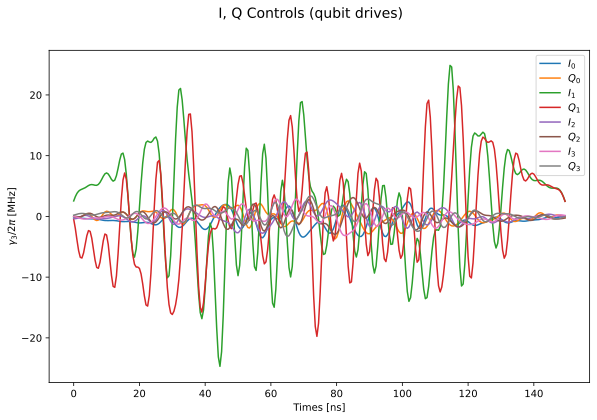

In [265]:
print("Fidelity:", 1-ctrl_output["cost"]["value"])

control_times = []
I_values_pi = []
Q_values_pi = []
control_qubits = []
for q in range(qram.nqubits):
    if f"$\gammaI_{q}$" not in ctrl_output: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_output[name]
        for step, pulse in enumerate(control):
            if q==1 and j==0: control_times.append(t)
            t += pulse['duration']
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])

    I_values_pi.append(I_values_q)
    Q_values_pi.append(Q_values_q)
    control_qubits.append(q)

control_times = np.array(control_times)
I_values_pi = np.array(I_values_pi)
Q_values_pi = np.array(Q_values_pi)
control_qubits = np.array(control_qubits)

I_values = I_values_pi
Q_values = Q_values_pi
# plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values.flatten(), Q_values.flatten()))))

controls_index = 0
for q in range(qram.nqubits):
    if f"$\gammaI_{q}$" not in ctrl_output: continue
    # plt.subplot(int(f'41{q+1}'))
    plt.plot(control_times, 1e3*I_values[controls_index], label=f'$I_{q}$')
    plt.plot(control_times, 1e3*Q_values[controls_index], label=f'$Q_{q}$')
    plt.ylim(-1e3*ymax, 1e3*ymax)
    plt.ylabel(f'$\gamma_{q}/2\pi$ [MHz]')
    plt.legend()
    controls_index += 1
plt.xlabel('Times [ns]')
# plt.tight_layout()
plt.show()

import into pulse sequence

In [266]:
seq = PulseSequence(start_time=0)
# for q in range(4):

qubit_frame = 1 # qubit frequency to rotate at
print(f'using rotating frame of qubit {qubit_frame}')
gstate = 'gggg'
estate = gstate[:qubit_frame]+'e'+gstate[qubit_frame+1:]
print(gstate, estate)
wframe = qram.get_base_wd(gstate, estate)
print(wframe/2/np.pi)

control_index = 0
for q in control_qubits:
    seq.pulse_IQ(wd=wframe, amp=1, pulse_levels=(gstate, estate), I_values=I_values[q], Q_values=Q_values[q], times=control_times, drive_qubit=q, t_start=0, phase=0)
    print(f'added pulse IQ on qubit {q}')
    control_index += 1

using rotating frame of qubit 1
gggg gegg
3.451200416325579
added pulse IQ on qubit 0
added pulse IQ on qubit 1
added pulse IQ on qubit 2
added pulse IQ on qubit 3


### Plot pulse seq envelopes

[3.451200416325579, 3.451200416325579, 3.451200416325579, 3.451200416325579] (GHz)
[149.5, 149.5, 149.5, 149.5] (ns)
total pulse length 598.0 ns


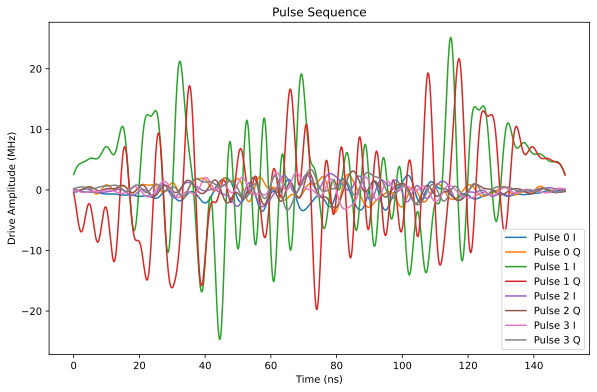

In [267]:
envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
pulse_freqs = seq.get_pulse_freqs()
pulse_lens = seq.get_pulse_lengths()
drive_funcs = seq.get_pulse_seq()
print(seq.get_pulse_freqs(), '(GHz)')
print(pulse_lens, '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')

times = np.linspace(0, seq.get_pulse_lengths()[-1], 900)

flat_times = np.array(times).flatten()
envelope_v_times = []
for i in range(len(envelope_seq)):
    if isinstance(envelope_seq[i], list) and len(envelope_seq[i]) == 2:
        envelope_v_time_I = [pulse_amps[i]*envelope_seq[i][0](t)*1e3 for t in flat_times]
        envelope_v_time_Q = [pulse_amps[i]*envelope_seq[i][1](t)*1e3 for t in flat_times]
        plt.plot(flat_times, envelope_v_time_I, label=f'Pulse {i} I')
        plt.plot(flat_times, envelope_v_time_Q, label=f'Pulse {i} Q')
    else:
        envelope_v_time = [pulse_amps[i]*envelope_seq[i](t)*1e3 for t in flat_times]
        envelope_v_times.append(envelope_v_time)
        plt.plot(flat_times, envelope_v_time, label=f'Pulse {i}')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
# plt.xlim(0, 100)
plt.title('Pulse Sequence')
plt.legend()
plt.show()

## Run simulation

SIMULATE

In [269]:
# psi0 = qram.state(psi0_name)
# psi0 = qram.state('gegg')
psi0 = (qram.state('gggg') + qram.state('eggg')).unit()
# psi0 = (qram.state('gggg') + 1j*qram.state('ggge') + 1j*qram.state('gegg') - qram.state('gege')).unit()
# psi0 = (qram.state('gggg') + qram.state('gegg')).unit()
# psi0 = (qram.state('eggg') + 1j*qram.state('eegg')).unit()
# psi0 = (qram.state('eggg', esys=esys_rot_wd) + 1j*qram.state('eegg', esys=esys_rot_wd)).unit()
# psi0 = (qram.make_bare('eggg') + 1j*qram.make_bare('eegg')).unit()
# psi0 = (qram.state('ggeg') + qram.state('geeg')).unit()
# psi0 = (qram.state('ggge') + qram.state('gege')).unit()

# result_lab = qram.evolve(psi0, seq, times, c_ops=None, nsteps=200, use_str_solve=False)
# result = qram.evolve_rot_frame(psi0, seq, times, c_ops=None, nsteps=20000)

result_lab = qt.mesolve(qram.H_solver_rot_wd(seq=seq, wframe=wframe), psi0, times, progress_bar=True, options=qt.Options(nsteps=1000)).states

10.0%. Run time:   0.32s. Est. time left: 00:00:00:02
20.0%. Run time:   0.70s. Est. time left: 00:00:00:02
30.0%. Run time:   1.08s. Est. time left: 00:00:00:02
40.0%. Run time:   1.46s. Est. time left: 00:00:00:02
50.0%. Run time:   1.84s. Est. time left: 00:00:00:01
60.0%. Run time:   2.24s. Est. time left: 00:00:00:01
70.0%. Run time:   2.63s. Est. time left: 00:00:00:01
80.0%. Run time:   3.00s. Est. time left: 00:00:00:00
90.0%. Run time:   3.37s. Est. time left: 00:00:00:00
Total run time:   3.78s


In [270]:
result = result_lab
# result = qram.evolve_unrotate(times=times, result=result_lab)
# result = qram.evolve_unrotate(times=[times[-1]], result=[result_lab[-1]])

Plot evolution results

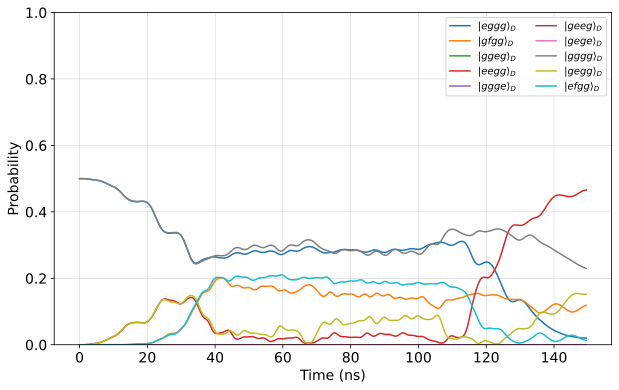

In [271]:
saveplot = False

plt.figure(figsize=(10,6))
if saveplot: plt.style.use('dark_background')

# states for 1 input
# plot_states = ['eggg', 'gfgg', 'ggeg', 'eegg', 'ggge', 'geeg', 'gege', 'gggg', 'gegg']
plot_states = ['eggg', 'gfgg', 'ggeg', 'eegg', 'ggge', 'geeg', 'gege', 'gggg', 'gegg', 'efgg'] #, 'ehgg', 'ghgg']
prob_states = dict()
for state in plot_states:
    psi = qram.state(state)
    # print(np.abs(psi.overlap(result[-1]))**2)
    prob_states.update({state:[np.abs(psi.overlap(result[t]))**2 for t in range(len(times))]})

for state in plot_states:
    plt.plot(times, prob_states[state], label=rf'$|{state}\rangle_D$')

plt.legend(fontsize=10, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)

if saveplot:
    plot_filename = 'qram_protocol_simulated.png'
    plt.savefig(plot_filename, format='png', bbox_inches='tight', transparent = True)
    print('Saved', plot_filename)

plt.show()

## Truncate result so it's compatible with 2q tomography

Get ideal rho

In [ ]:
gate_duration = times[-1]
# IDEAL GATE: written in the dressed basis
# pad X unitary to full Hilbert space for 1
Xfull = np.eye(cutoffs[1], dtype=complex)
X = qt.qip.operations.rx(np.pi)
X = np.array(X)
# Xfull[:2, :2] = np.array([[0, 1], [1, 0]])
Xfull[:2, :2] = X
Xfull = qt.Qobj(Xfull, dims=[[cutoffs[1]], [cutoffs[1]]])

target_operator = qt.tensor([qt.qeye(cutoffs[0]), Xfull, qt.qeye(cutoffs[2]), qt.qeye(cutoffs[3])])
target_operator = target_operator.full()
print(target_operator)


# PROJECT ONTO SUBSPACE
# projection operator written in the dressed basis
# project onto subspace of Q1 with other qubits in g or single excitation gxgg, exgg, gxeg, gxge
projected_basis = []
qubit_states = [None]*4
for q in range(4):
    gstate = qt.basis(cutoffs[q], 0)
    estate = qt.basis(cutoffs[q], 1)
    qubit_states[q] = [gstate, estate]

for q in range(4):
    tensor_state = [qt.basis(cutoffs[q], 0) for q in range(4)] # gggg
    if q != 1:
        tensor_state[q] = qubit_states[q][1] # estate
    for q1_state in qubit_states[1]:
        tensor_state[1] = q1_state
        projected_basis.append(qt.tensor(*tensor_state))
computational_projector = np.zeros(shape=(np.prod(cutoffs), np.prod(cutoffs)), dtype=np.complex128)
for state in projected_basis:
    computational_projector += (state * state.dag()).full()
print(computational_projector)

target_operator = computational_projector.conjugate().T @ target_operator @ computational_projector
print(target_operator)
# print(target_operator.shape)


H = qram.H_rot(wd=qram.get_base_wd('gggg', 'gegg'))

# # TAKE THE IDEAL OPERATOR FROM DRESSED TO FOCK BASIS
# evals, evecs = H.eigenstates()
# # Dressed eigenstates written in fock basis, evecs should be columns
# R_dressed_to_fock = np.array([evec.unit().full().flatten() for evec in evecs]).T
# target_operator = R_dressed_to_fock.conjugate().T @ target_operator @ R_dressed_to_fock


# TAKE THE IDEAL OPERATOR FROM RF OF ALL QUBITS -> FRAME OF SIMS
R_rf_to_lab = (-1j*H*gate_duration).expm().full()
target_operator = R_rf_to_lab @ target_operator @ R_rf_to_lab.conjugate().T


# psi0 = (qram.state('gggg') + qram.state('eggg')).unit()
# print(psi0.dims)
# target_operator = qt.Qobj(target_operator, dims=[psi0.dims[0],psi0.dims[0]])
# # print(target_operator.dims)
# result_lab = [target_operator * psi0]


[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 1.+0.j]]
[[1.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


In [262]:
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psi00 = qt.tensor(psiZ[0], psiZ[0])
psi01 = qt.tensor(psiZ[0], psiZ[1])
psi10 = qt.tensor(psiZ[1], psiZ[0])
psi11 = qt.tensor(psiZ[1], psiZ[1])

# # rho_id = qt.ket2dm(psi00 + 1j*psi01 - 1j*psi10 + psi11).unit()
# rho_id = qt.ket2dm(psi01 + psi11).unit()
# # rho_id = qt.ket2dm(psi00 - 1j*psi01 + psi10 - 1j*psi11).unit()
# # rho_id = qt.ket2dm(psi11).unit()
# print(rho_id.shape, rho_id.dims)


rho_id = qt.Qobj(target_operator @ psi0.full(), dims=psi0.dims)
rho_id = rho_id * rho_id.dag()
rho_id = qt.ptrace(rho_id.unit(), tomo_qubits)
orig_dims = result2q.dims[0]
states_inds = [i*orig_dims[1]+ j for i in range(2) for j in range(2)]
rho_id = rho_id.extract_states(states_inds, normalize=True)
id2q = qt.tensor(qt.qeye(2), qt.qeye(2))
rho_id  = qt.Qobj(rho_id , dims=id2q.dims, shape=id2q.shape).unit()
print(rho_id.shape, rho_id.dims)

(4, 4) [[2, 2], [2, 2]]


Get 2Q partial trace density matrix

In [ ]:
result = qram.evolve_unrotate(times=[times[-1]], result=[result_lab[-1]])

Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 2.75531502e-03-1.63461189e-20j -1.95766677e-02+6.21835615e-03j
   8.97880425e-04-2.14681115e-04j -1.48357497e-03-1.03310767e-03j
   2.09464693e-02+7.70823571e-05j -4.48204148e-04+1.98634063e-05j
  -1.10239123e-03-3.56463158e-06j  3.23676837e-05-4.79662143e-06j
   4.84785613e-08-8.76151086e-08j]
 [-1.95766677e-02-6.21835615e-03j  4.97342705e-01-6.96875012e-20j
  -2.19679267e-02-1.26188036e-03j -1.10623705e-02+8.53879301e-03j
  -4.74511812e-01-1.44666156e-01j  1.03244744e-02+2.62162687e-03j
   2.49716581e-02+7.60809273e-03j -7.68781660e-04-1.12751381e-04j
  -1.70301922e-06+1.66064424e-06j]
 [ 8.97880425e-04+2.14681115e-04j -2.19679267e-02+1.26188036e-03j
   9.73845131e-04+5.55625848e-21j  4.47466591e-04-4.00590940e-04j
   2.13347816e-02+5.18690487e-03j -4.62856027e-04-8.96166246e-05j
  -1.12275075e-03-2.72737075e-04j  3.42557881e-05+3.02953924e-06j
   7.10320437e-08-7.77020743e-08j]
 [-1.48

 C:\Users\slab\AppData\Local\Temp\ipykernel_7032\2539742270.py: 21UserWarning: The figure layout has changed to tight
 C:\Users\slab\AppData\Local\Temp\ipykernel_7032\2539742270.py: 48

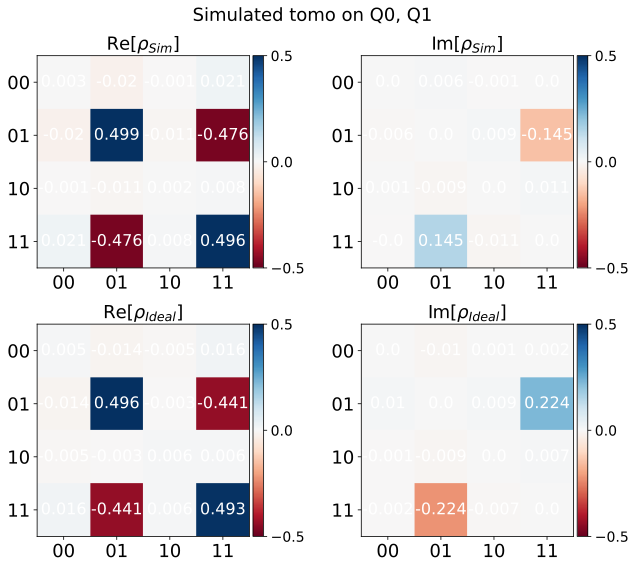

Fidelity: 0.8588265178992213
Purity (sim): 0.9921982758089949
Purity (ideal): 0.979477984892398


In [263]:
# print(result[-1].dims)
tomo_qubits = [0, 1]
# tomo_qubits = [2, 3]
# tomo_qubits = [1, 2]
# tomo_qubits = [1, 3]
# result[-1] = psi0
result2q = qt.ptrace(result[-1].unit(), tomo_qubits)
# result2q = qt.ptrace(psi0, tomo_qubits)
orig_dims = result2q.dims[0]
# result2q = qt.ptrace(result.unit(), tomo_qubits)
# print('orig dims', orig_dims)
# rho_result2q = result2q
print(result2q)

states_inds = [i*orig_dims[1]+ j for i in range(2) for j in range(2)]
# print('extract state indices', states_inds)
rho_result2q = result2q.extract_states(states_inds, normalize=True)


id2q = qt.tensor(qt.qeye(2), qt.qeye(2))
rho_result2q  = qt.Qobj(rho_result2q , dims=id2q.dims, shape=id2q.shape).unit()
print(rho_result2q)

show_plot_rho_2d(rho_sim=rho_result2q.full(), rho_id=rho_id.full(), title=f'Simulated tomo on Q{tomo_qubits[0]}, Q{tomo_qubits[1]}', cmax=0.5) #, savetitle='0_0+1_simulated_flat.png') #, cmax=1.0)

fid = qt.fidelity(rho_result2q, rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_sim = np.real(np.trace(rho_result2q.full() @ rho_result2q.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity: {fid}')
print(f'Purity (sim): {purity_sim}')
print(f'Purity (ideal): {purity_id}')